#### Config and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join("../"))

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from IPython.display import clear_output
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

2022-10-08 21:10:38.515946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-08 21:10:40.549797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-08 21:10:40.551060: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-08 21:10:40.990087: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-08 21:10:46.728835: W tensorflow/stream_executor/platform/de

#### Auxiliary Functions

In [4]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [5]:
def display(display_list):
  print(type(display_list))
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
    
  plt.show()

### Get Test Data

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_batches = test_images.batch(64)

2022-10-08 21:10:52.703610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-08 21:10:52.704275: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-08 21:10:52.704333: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sim-virtual-machine): /proc/driver/nvidia/version does not exist
2022-10-08 21:10:52.707361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
test_data = []
for images, masks in test_batches.take(200):
  sample_image, sample_mask = images[0], masks[0]
  test_data.append((sample_image, sample_mask))

### Test Model

In [8]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [9]:
def show_predictions(model, image_num = 0):
  sample_image, sample_mask = test_data[image_num]
  display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 801ms/step
<class 'list'>


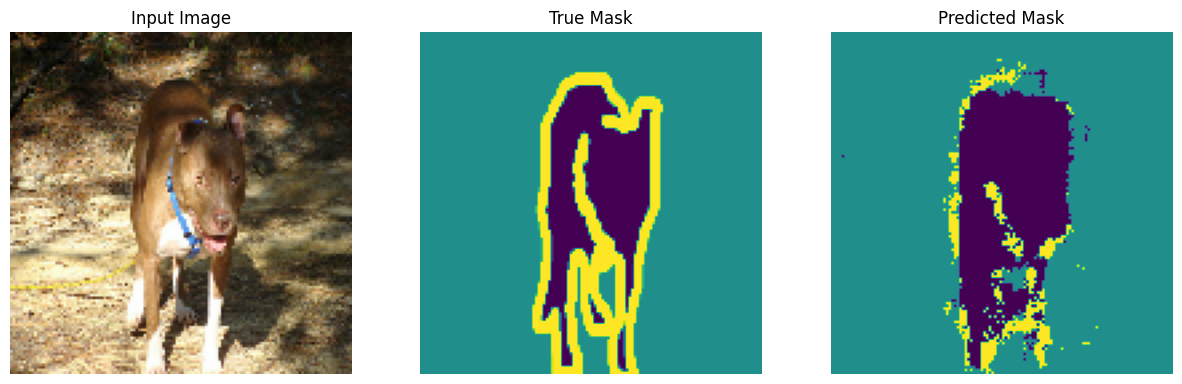

In [13]:
model = tf.keras.models.load_model("../model/saved")
show_predictions(model, 4)